In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import normalize
import random

In [2]:
experiment = "../output/pretrain_224"
embeddings = np.load(f"{experiment}/embeddings.npy")
info = np.load(f"{experiment}/info.npy")
train_embeddings = np.load(f"{experiment}/train_embeddings.npy")
train_info = np.load(f"{experiment}/train_info.npy")
embeddings = embeddings.T
embeddings.shape, info.shape



((30978, 2048), (2, 30978))

In [3]:
mu = embeddings.mean(axis=1)
mu = np.expand_dims(mu, axis=1) 
norm_embeddings = (embeddings-mu)
norm_embeddings /= np.expand_dims(np.linalg.norm(norm_embeddings,axis=1), axis=1)
np.linalg.norm(norm_embeddings,axis=1), norm_embeddings.mean()

(array([0.9999995 , 0.9999999 , 0.9999994 , ..., 1.0000001 , 1.        ,
        0.99999976], dtype=float32),
 -1.582569e-10)

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(norm_embeddings)
embeddings_pca.shape
pca.explained_variance_ratio_[0:3].sum(), pca.explained_variance_ratio_[0:3], pca.explained_variance_ratio_.sum()


(0.19923058,
 array([0.09311868, 0.05805342, 0.0480585 ], dtype=float32),
 0.76136744)

In [5]:
from sklearn.manifold import TSNE
embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings)
embeddings_tsne.shape

(30978, 2)

In [6]:

widget_categories = widgets.Combobox(
    # value='John',
    placeholder='all',
    options=['all','bike', 'book', 'bottle', 'camera','cereal_box','chair', 'couch', 'cup', 'eyeglass', 'laptop', 'shoe'],
    description='Categories:',
    ensure_option=True,
    disabled=False
)

In [7]:
info_df = pd.DataFrame(info.T).rename(columns={0:"class_id",1:"uid"})
len(info_df)

30978

In [8]:
train_info_df = pd.DataFrame(train_info.T).rename(columns={0:"class_id",1:"uid"})

In [9]:
info_df

,class_id,uid
0,6,hdf5_cup/00737_260
1,5,hdf5_chair/00772_0
2,7,hdf5_laptop/00759_210
3,1,hdf5_book/01022_50
4,2,hdf5_bottle/01070_200
...,...,...
30973,4,hdf5_cereal_box/00890_260
30974,6,hdf5_cup/01284_190
30975,6,hdf5_cup/00409_180
30976,0,hdf5_bike/00198_91


In [10]:
info_df["category"]=info_df["uid"].str.extract("hdf5_(.*?)/")
info_df["sequence_id"]=info_df["uid"].str.extract("/(\d+)_")
info_df["frame_id"]=info_df["uid"].str.extract("_(\d+)$").astype(int)
info_df["sequence_uid"] = info_df["category"] + "_" + info_df["sequence_id"]
selected = info_df.query(f"category=='shoe' and sequence_id=='batch-35_37'").index

In [11]:
info_df

,class_id,uid,category,sequence_id,frame_id,sequence_uid
0,6,hdf5_cup/00737_260,cup,00737,260,cup_00737
1,5,hdf5_chair/00772_0,chair,00772,0,chair_00772
2,7,hdf5_laptop/00759_210,laptop,00759,210,laptop_00759
3,1,hdf5_book/01022_50,book,01022,50,book_01022
4,2,hdf5_bottle/01070_200,bottle,01070,200,bottle_01070
...,...,...,...,...,...,...
30973,4,hdf5_cereal_box/00890_260,cereal_box,00890,260,cereal_box_00890
30974,6,hdf5_cup/01284_190,cup,01284,190,cup_01284
30975,6,hdf5_cup/00409_180,cup,00409,180,cup_00409
30976,0,hdf5_bike/00198_91,bike,00198,91,bike_00198


In [21]:
import re
def parse_hdf5_uid(uid):
    m = re.match("hdf5_(\w+)/(\d+)_(\d+)", uid)
    category, sequence, image_id = m[1],m[2], int(m[3])
    return category, sequence, image_id 
category, sequence, image_id = parse_hdf5_uid("hdf5_shoe/01685_180")
category, sequence, image_id 

('shoe', '01685', 180)

In [22]:
import h5py
dataset = h5py.File('/home/raphael/datasets/objectron/extract_s5_raw.hdf5','r')

In [23]:
import cv2
image_idx = list(dataset[category][sequence]["IMAGE_ID"]).index(image_id)
img= cv2.imdecode(dataset[category][sequence]["IMAGE"][image_idx],cv2.IMREAD_ANYCOLOR)
cv2.imwrite("/tmp/toto.jpg",img)

True

In [24]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [25]:
def save_jpg(uid):
    category, sequence, image_id = parse_hdf5_uid(uid)
    image_idx = list(dataset[category][sequence]["IMAGE_ID"]).index(image_id)
    img= cv2.imdecode(dataset[category][sequence]["IMAGE"][image_idx],cv2.IMREAD_ANYCOLOR)
    basename = uid.replace("/","_")
    jpeg_filename = f"tmp/{basename}.jpg"
    #jpeg_filename = "preview.jpeg"
    cv2.imwrite(jpeg_filename,img)
    return jpeg_filename
save_jpg("hdf5_shoe/01685_180")

'tmp/hdf5_shoe_01685_180.jpg'

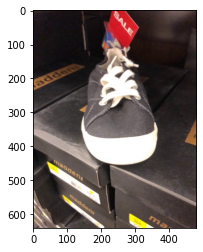

In [26]:
from cv2_plt_imshow import cv2_plt_imshow
cv2_plt_imshow(img)

In [27]:
import re
uid = "hdf5_bike/00007_20"
m = re.match("hdf5_(\w+)/(\d+)_(\d+)", uid)
category, sequence, frame = m[1],m[2],m[3]

In [28]:
def filepath_from_uid(uid, subset="valid"):
    return save_jpg(uid)

def image_tag(file_path, title=None, caption="n/a"):
    if title is None:
        title=file_path
    return f"<div style='width:100px;height:120px;float:left;'><div>{caption}</div><img src='{file_path}' title={title}></img></div>"

In [29]:
out2d = widgets.HTML()

fig2d = go.FigureWidget(data=[go.Scatter(
    #height=600,
    x=embeddings_tsne[:,0],
    y=embeddings_tsne[:,1],
    text=info[1],
    mode='markers',
    marker=dict(
        size=3,
        color=info[0].astype(int),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.6
    )
)])
def update_point(trace, points, selector):
    global out
    global info
    global scatter
    point_id = points.point_inds[0]
    uid=scatter.text[point_id]
    file_path = filepath_from_uid(uid)
    out2d.value=image_tag(file_path, caption="")

scatter = fig2d.data[0]
#fig2d.update_layout({"height": 800})
scatter.on_hover(update_point)
display(out2d)
display(fig2d)


HTML(value='')

FigureWidget({
    'data': [{'marker': {'color': array([6, 5, 7, ..., 6, 0, 3]),
                         'col…

In [30]:

projected_embeddings=embeddings_pca
#projected_embeddings=embeddings_tsne

df = pd.DataFrame(projected_embeddings)
fig = go.FigureWidget(data=[go.Scatter3d(
    x=projected_embeddings[:,0],
    y=projected_embeddings[:,1],
    z=projected_embeddings[:,2],
    text=info[1],
    mode='markers',
    marker=dict(
        size=1,
        color=info[0].astype(int),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.6
    )
)])
scatter = fig.data[0]
fig.layout.hovermode = 'closest'

out = widgets.HTML()
display(out)
out.value="<p>Hi there!</p>"

# create our callback function
def update_point(trace, points, selector):
    global out
    global info
    global scatter
    point_id = points.point_inds[0]
    uid=scatter.text[point_id]
    file_path = save_jpg(uid)
    out.value=image_tag(file_path, caption="")

def change_category(x):
    global scatter
    global projected_embeddings
    global info_df
    
    if x=="all":
        scatter.x = projected_embeddings[:,0]
        scatter.y = projected_embeddings[:,1]
        scatter.z = projected_embeddings[:,2]
        scatter.text = info_df["uid"]
    else:
        indices = info_df["uid"].str.contains(x)
        scatter.x = projected_embeddings[indices,0]
        scatter.y = projected_embeddings[indices,1]
        scatter.z = projected_embeddings[indices,2]  
        scatter.text = info_df[info_df["uid"].str.contains(x)]["uid"]

    return 
scatter.on_hover(update_point)
interact(change_category, x=widget_categories)
display(fig)


HTML(value='')

interactive(children=(Combobox(value='', description='Categories:', ensure_option=True, options=('all', 'bike'…

FigureWidget({
    'data': [{'marker': {'color': array([6, 5, 7, ..., 6, 0, 3]),
                         'col…

In [31]:
similarity_matrix = np.dot(embeddings,embeddings.T)

In [32]:
import pandas as pd
np.fill_diagonal(similarity_matrix,0)

In [33]:
train_info_df["category"]=train_info_df["uid"].str.extract("(.*?)-")
train_info_df["sequence_id"]=train_info_df["uid"].str.extract("(batch-\d+_\d+_\d+)")
train_info_df["frame_id"]=train_info_df["uid"].str.extract("(\d+)$")
train_info_df["sequence_uid"] = train_info_df["category"] + "_" + train_info_df["sequence_id"]

In [34]:
categories = info_df["category"].unique()


In [35]:
visited = [0]

def visit(node, similarity_matrix, k=1, threshold=0.95):
    i=node
    nn = (-similarity_matrix[i]).argsort()[0:k]
    valid_nn = []
    for j in nn:
        if similarity_matrix[i,j] > threshold:
            valid_nn.append(j)
    return valid_nn
visit(0, similarity_matrix)

[12919]

In [36]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import gc
gc.collect()

45

In [37]:
sequences_combo = widgets.Combobox(
    placeholder='Choose Sequence',
    options=list(info_df["uid"].unique()),
    description='Combobox:',
    ensure_option=True,
    disabled=False
)
which_radio = widgets.RadioButtons(
    options=['all', 'others', 'exclusive'],
    description='Show neighbors from sequences:',
    disabled=False
)

In [38]:
similarity_matrix

array([[0.        , 0.60394543, 0.5412717 , ..., 0.70243686, 0.7129862 ,
        0.6508885 ],
       [0.60394543, 0.        , 0.6010018 , ..., 0.70986164, 0.72413176,
        0.67676026],
       [0.5412717 , 0.6010018 , 0.        , ..., 0.5898309 , 0.64631194,
        0.6432031 ],
       ...,
       [0.70243686, 0.70986164, 0.5898309 , ..., 0.        , 0.7779028 ,
        0.695629  ],
       [0.7129862 , 0.72413176, 0.64631194, ..., 0.7779028 , 0.        ,
        0.63734573],
       [0.6508885 , 0.67676026, 0.6432031 , ..., 0.695629  , 0.63734573,
        0.        ]], dtype=float32)

In [39]:
out_similar = widgets.HTML()
which = "all"

def f(x, which):
    global out_similar
    max_thumb = 6
    idx =info_df[info_df["uid"]==x].index[0]
    sequence_uid = info_df.iloc[idx]["sequence_uid"]
    neighbors = visit(idx, similarity_matrix, k=1000, threshold=0)
    valid_neighbbors = neighbors
    sequence_uids = [sequence_uid]
    if which=="others" or which=="exclusive":
        valid_neighbbors=[]
        for n in neighbors:
            sequence_uid = str(info_df.iloc[n]["sequence_uid"])
            if not sequence_uid in sequence_uids:
                valid_neighbbors.append(n)
            if which=='exclusive':
                sequence_uids.append(sequence_uid)

    html="<div>"
    file_path = save_jpg(x)
    print(file_path)
    html+=image_tag(file_path,x, caption="similarity:")
    for i, n in enumerate(valid_neighbbors):
        uid = info_df.iloc[n]["uid"]
        file_path = filepath_from_uid(uid)
        html+=image_tag(file_path, uid, caption=f"{similarity_matrix[idx, n]:.2f}")
        if i > max_thumb:
            break
    html+="</div>"
    out_similar.value = html
    return 


def g(x):
    global which
    which = x
    
print(categories)
display(out_similar)
interact(f, x=sequences_combo, which=which_radio)
#interact(g, o)

['cup' 'chair' 'laptop' 'book' 'bottle' 'cereal_box' 'shoe' 'bike'
 'camera']


HTML(value='')

interactive(children=(Combobox(value='', description='Combobox:', ensure_option=True, options=('hdf5_cup/00737…

<function __main__.f(x, which)>

In [40]:
def visit_train(embedding, train_embeddings, k=1000, threshold=0.5):
    #i=node
    similarity_vector = np.dot(embedding, train_embeddings)
    nn = (-similarity_vector).argsort()[0:k]
    valid_nn = []
    for j in nn:
        if similarity_vector[j] > threshold:
            valid_nn.append(j)
    return valid_nn, similarity_vector

In [41]:
sequences_combo_train = widgets.Combobox(
    placeholder='Choose Sequence',
    options=list(info_df["uid"].unique()),
    description='Combobox:',
    ensure_option=True,
    disabled=False
)
which_radio_train = widgets.RadioButtons(
    options=['all', 'others', 'exclusive'],
    description='Show neighbors from sequences:',
    disabled=False
)

In [42]:
out_similar = widgets.HTML()
which = "all"

def f_train(x, which):
    global out_similar
    
    max_thumb = 6
    idx =info_df[info_df["uid"]==x].index[0]
    sequence_uid = info_df.iloc[idx]["sequence_uid"]
    
    neighbors, similarity_vector = visit_train(embeddings[idx], train_embeddings, k=1000, threshold=0)
    print(idx)
    valid_neighbbors = neighbors
    sequence_uids = {sequence_uid: True}
    valid_neighbbors_idx = []
    if which=="others" or which=="exclusive":
        valid_neighbbors=[]
        for i, n in enumerate(neighbors):
            sequence_uid = str(train_info_df.iloc[n]["sequence_uid"])
            if not sequence_uid in sequence_uids:
                valid_neighbbors.append(n)
                valid_neighbbors_idx.append(i)
                if which=='exclusive':
                    sequence_uids[sequence_uid] = True

    html="<div>"
    file_path = filepath_from_uid(x)
    html+=image_tag(file_path,x, caption="similarity:")
    for i, n in enumerate(valid_neighbbors):
        uid = train_info_df.iloc[n]["uid"]
        k = valid_neighbbors_idx[i]
        file_path = filepath_from_uid(uid, subset="train")
        html+=image_tag(file_path, uid, caption=f"{similarity_vector[n]:.2f}, k={k}")
        if i > max_thumb:
            break
        #print(file_path)
    html+="</div>"
    out_similar.value = html
    return 


def g(x):
    global which
    which = x
    
print(categories)
display(out_similar)
interact(f_train, x=sequences_combo_train, which=which_radio_train)


['cup' 'chair' 'laptop' 'book' 'bottle' 'cereal_box' 'shoe' 'bike'
 'camera']


HTML(value='')

interactive(children=(Combobox(value='', description='Combobox:', ensure_option=True, options=('hdf5_cup/00737…

<function __main__.f_train(x, which)>

In [154]:
info_df["sequence_uid"]

0        bike_00007
1        bike_00007
2        bike_00007
3        bike_00007
4        bike_00007
            ...    
30973    shoe_01685
30974    shoe_01685
30975    shoe_01685
30976    shoe_01685
30977    shoe_01685
Name: sequence_uid, Length: 30978, dtype: object

In [155]:
sequence_embeddings_info = info_df[info_df["sequence_uid"]=="bike_00007"]
sequence_embeddings = embeddings[sequence_embeddings_info.index]
sequence_pca = PCA(n_components=10)
sequence_embeddings_pca = sequence_pca.fit_transform(sequence_embeddings)
sequence_embeddings_info = sequence_embeddings_info.reset_index()

In [156]:


widget_sequence_uid = widgets.Combobox(
    # value='John',
    placeholder='shoe_batch-35_37',
    options=list(info_df["sequence_uid"].unique()),
    description='Categories:',
    ensure_option=True,
    disabled=False
)


df = pd.DataFrame(projected_embeddings)
fig = go.FigureWidget(data=[go.Scatter3d(
    x=sequence_embeddings_pca[:,0],
    y=sequence_embeddings_pca[:,1],
    z=sequence_embeddings_pca[:,2],
    text=sequence_embeddings_info["uid"],
    mode='markers',
    marker=dict(
        size=3,
        color=info[0].astype(int),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.6
    )
)])
scatter2 = fig.data[0]
fig.layout.hovermode = 'closest'

out2 = widgets.HTML()
display(out2)
out.value="<p>Hi there!</p>"

# create our callback function
def update_point2(trace, points, selector):
    global out2
    global info
    global scatter2
    point_id = points.point_inds[0]
    #dataset_dir="../datasets/objectron_96x96/valid"
    uid=scatter2.text[point_id].split(",")[0]
    file_path = filepath_from_uid(uid)
    out2.value=image_tag(file_path, caption="")

def change_sequence_uid(sequence_uid):
    global scatter2
    global embeddings
    global info_df
    global sequence_embeddings_pca, sequence_embeddings_info, sequence_embeddings
    if len(sequence_uid)==0:
        sequence_uid="bike_batch-3_10"
    sequence_embeddings_info = info_df[info_df["sequence_uid"]==sequence_uid]
    sequence_embeddings = embeddings[sequence_embeddings_info.index]
    sequence_pca = PCA(n_components=10)
    print("Gluk!")
    sequence_embeddings_pca = sequence_pca.fit_transform(sequence_embeddings)
    
    sequence_embeddings_info = sequence_embeddings_info.reset_index()

    scatter2.x = list(sequence_embeddings_pca[:,0])
    scatter2.y = sequence_embeddings_pca[:,1]
    scatter2.z = sequence_embeddings_pca[:,2]

    scatter2.text = sequence_embeddings_info["uid"] + ","+ sequence_embeddings_info["index"].astype(str)
    return 

display(fig)
scatter2.on_hover(update_point2)
interact(change_sequence_uid, sequence_uid=widget_sequence_uid)



HTML(value='')

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, ..., 8, 8, 8]),
                         'col…

interactive(children=(Combobox(value='', description='Categories:', ensure_option=True, options=('bike_00007',…

<function __main__.change_sequence_uid(sequence_uid)>